# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [81]:
# Load pickled data
import pickle
import csv
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
from tensorflow.contrib.layers import flatten

In [82]:
# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [83]:
sign_names_file = 'signnames.csv'
sign_names = []
with open(sign_names_file, 'r') as f:
    reader = csv.reader(f) 
    for row in reader:
        sign_names.append(row)

In [84]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = train['sizes'][0]

# TODO: how many classes are in the dataset
n_classes = len(X_train[0])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [29 30]
Number of classes = 32


In [85]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

#Organize data
signCounts = {}
signExamples = {}

numOfSigns = 42

for i in range(0, numOfSigns+1):
    signCounts[i] = 0

for i in range(len(y_train)):
    signCounts[y_train[i]] += 1
    signExamples[y_train[i]] = X_train[i]
    
fracs = []
labels = []
explode = []
sampleImages = []
for i in range(0, numOfSigns+1):
    fracs.append(100*signCounts[i]/len(y_train))
    labels.append(sign_names[i+1][1])
    sampleImages.append(signExamples[i])
    explode.append(0)


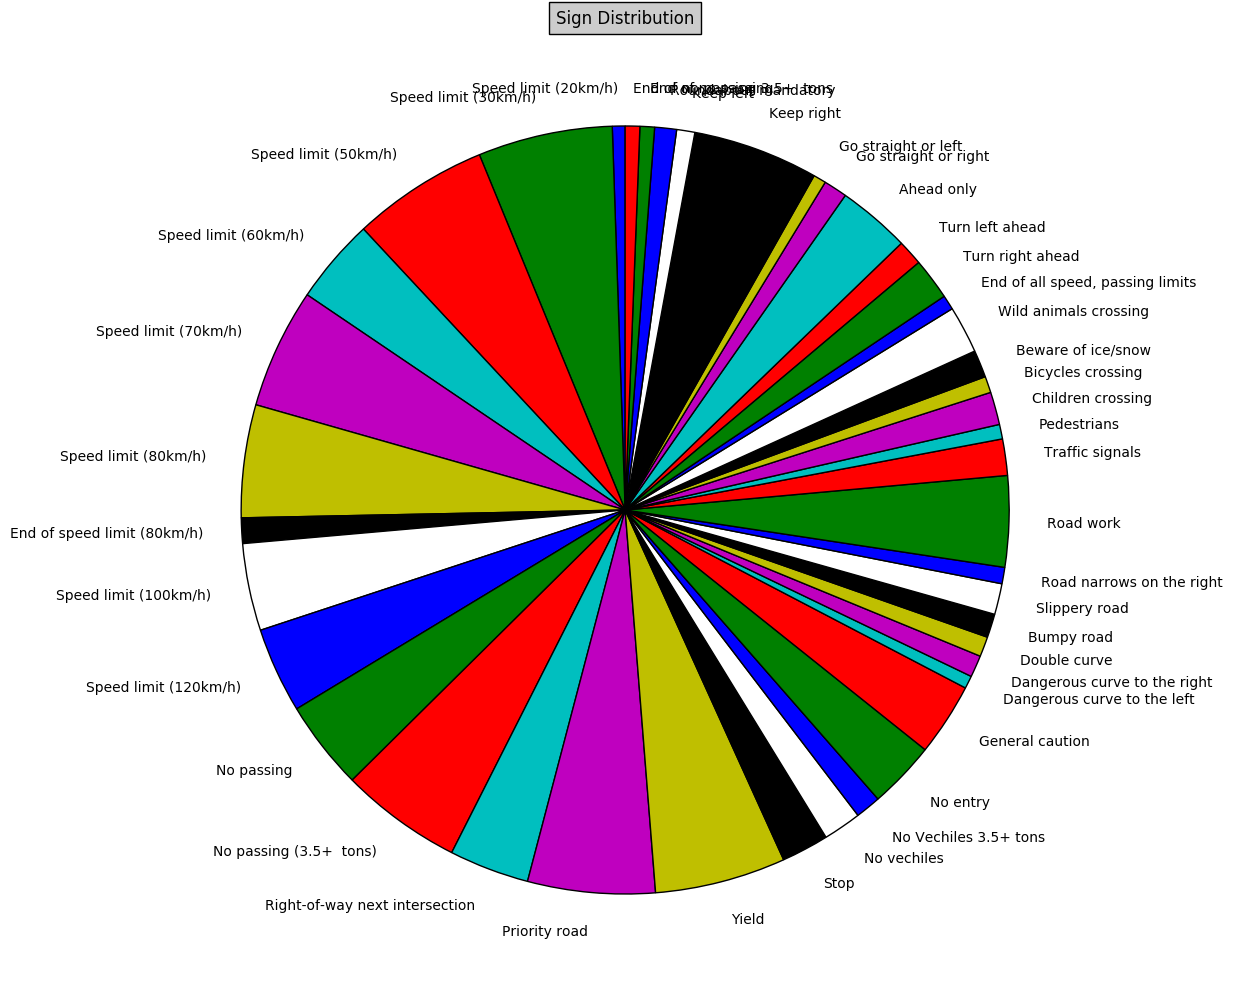

In [86]:
#Show pie chart of sign distribution
figure(1, figsize=(12,12))
ax = axes([0.1, 0.1, 0.8, 0.8])
pie(fracs, explode=explode, labels=labels,
                autopct='', shadow=False, startangle=90)
title('Sign Distribution', bbox={'facecolor':'0.8', 'pad':5})
show()

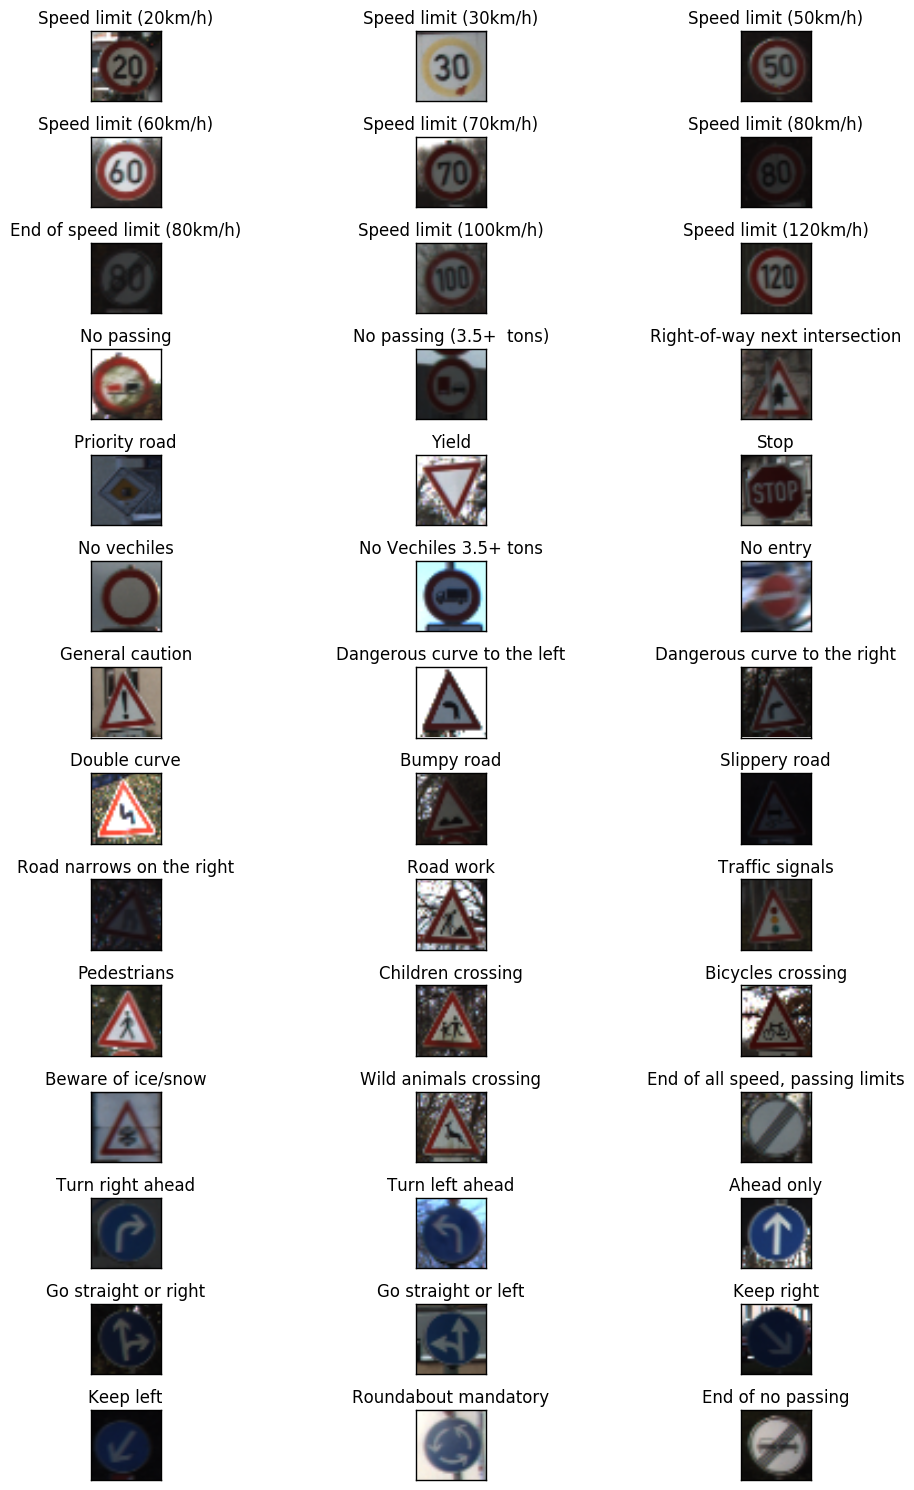

In [87]:
#Show sample images
plt.figure(figsize=(10,15))
for i in range(0, numOfSigns):
    axis = plt.subplot(numOfSigns/3,3,i+1)
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    img = Image.fromarray(sampleImages[i], 'RGB')
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [114]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#Convert to grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def process_image(img):
    img = grayscale(img)
    return normalize(img)

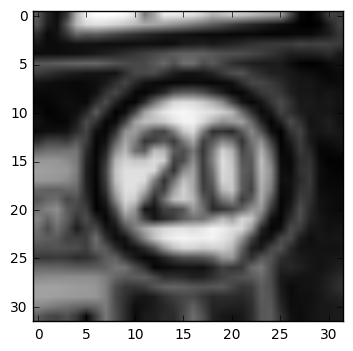

In [115]:
train_features = []
for i in range(len(X_train)):
    cur = X_train[i]
    cur = process_image(cur)
    train_features.append(cur)
    
test_features = []
for i in range(len(X_test)):
    cur = X_test[i]
    cur = process_image(cur)
    test_features.append(cur)

processed_image = train_features[12]
plt.imshow(processed_image, cmap='gray')

In [116]:
test_labels = y_test
train_labels = y_train

flattened_train_features = []
for image in train_features:
    feature = np.array(image, dtype=np.float32).flatten()
    flattened_train_features.append(feature)
train_features = flattened_train_features
    
flattened_test_features = []
for image in test_features:
    feature = np.array(image, dtype=np.float32).flatten()
    flattened_test_features.append(feature)
test_features = flattened_test_features
    
print("Features have been flattened")

Features have been flattened


In [117]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(test_labels)
test_labels = encoder.transform(test_labels)
train_labels = encoder.transform(train_labels)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
test_labels = test_labels.astype(np.float32)
train_labels = train_labels.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [118]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [119]:
# Save the data for easy access
pickle_file = 'traffic_sign.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('traffic_sign.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


# Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
As recommended in the NYU whitepaper, I decided to convert the traffic sign images to grayscale. Then I have flattened the images for easier processing in my CNN. Since there were only 42 different sign types, I could use One-Hot Encoding to get label tensors that my CNN could work with.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I randomly split the train data that was originally provided into a training and validation set. Randomization was key here since the data was originally ordered by sign type. Then I was able to isolate the original testing data while I was tuning my model so that my final test would provide a more accurate picture of how the model would perform. In order to avoid repeating the preprocessing steps, I saved everything into a pickle file.

Since the NYU team only saw incremental gains by generating new randomly rotated/altered images, I decided not to take that step in this iteration. 

## Reload Data

In [120]:
# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten

In [121]:
%matplotlib inline

# Reload the data
pickle_file = 'traffic_sign.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


## Training, Validation and Testing

In [122]:
#Image size is (32, 32)
# LeNet architecture:
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    # Squish values from 0-255 to 0-1.
    x /= 255.
    # Resize to 32x32.
    x = tf.image.resize_images(x, (32, 32))
    
    # Input shape going into the first convolutional layer is 32x32x1.
    # Convolution layer 1, 28x28x6.
    # Activation 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # Pooling layer 1, 14x14x6self.
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


    # Convolution layer 2, 10x10x16.
    # Activation 2
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16)))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)

    # Pooling layer 2. The output shape should be 5x5x16.
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten layer. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.
    fc1 = flatten(pool2)

    # Fully connected layer 1 with 120 outputs.
    # Activation 3. Your choice of activation function.
    fc1_W = tf.Variable(tf.truncated_normal(
        [5*5*16, 120]))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.reshape(
        fc1,
        [-1, fc1_W.get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, fc1_W),
        fc1_b)
    fc1 = tf.nn.tanh(fc1)
    
    # Fully connected layer 2 with 43 outputs.
    fc2_W = tf.Variable(tf.truncated_normal(
        [120, 43]))
    fc2_b = tf.Variable(tf.zeros(43))
    fc2 = tf.add(
        tf.matmul(fc1, fc2_W),
        fc2_b)
    # Return the result of the last fully connected layer.
    return fc2


# Traffic sign consists of 32x32x1, grayscale images.
features = tf.placeholder(tf.float32, (None, 1024))
# Classify over 43 traffic sign labels
labels = tf.placeholder(tf.float32, (None, 43))
# Create the LeNet.
fc2 = LeNet(features)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, labels))
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(labels, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Epoch 10/10: 100%|██████████| 291/291 [00:58<00:00, 16.94batches/s]


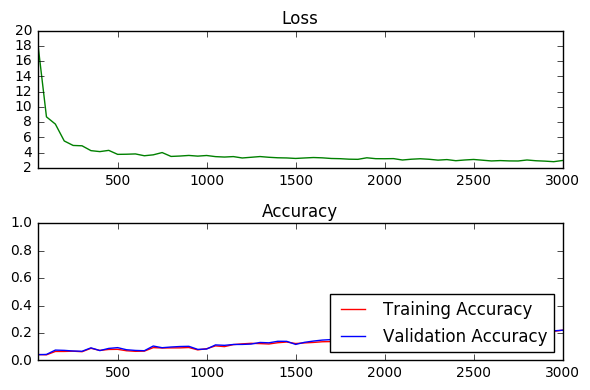

Validation accuracy at 0.19326874613761902


In [123]:
# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# ToDo: Find the best parameters for each configuration
epochs = 10
batch_size = 128 

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [train_op, loss_op],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy_op, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy_op, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy_op, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I decided to leverage the LeNet convolutional neural network that I had worked on in the previous assignment. This required me to make slight adjustments to the initial input reshaping and adjust the outputs to match the 43 possible traffic sign labels. The network retained it's original layer structure of input, first convolution, first activation, pooling layer, second convolution, second activation, second pooling layer, flatten layer, first fully connected layer, and final fully connected layer.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Originally I attempted to use 10 epochs, but my loss graph showed that the model ceased to improve significantly after the first ~5 epochs so I decided to use fewer. I also decided to experiment with a larger batch size of 640, rather than 64. This dropped my accuracy from 0.19 to 0.11, but drastically improved the training time. 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I began by adopting a proven image classification solution to my problem, then tweaked the algorithm to improve the performance.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [124]:
from PIL import Image                                                            
import numpy                                                                     
import matplotlib.pyplot as plt                                                  
import glob

#Load sample images
imageFolderPath = 'test_images/'
imagePath = glob.glob(imageFolderPath + '/*.jpg')
new_images = numpy.array( [numpy.array(Image.open(imagePath[i]).convert('L'), 'f') for i in range(len(imagePath))] )
convert_to_grayscale = False

# Code to load randome training images if desired
# np.random.shuffle(X_train)
# new_images = X_train[0:12]
# convert_to_grayscale = True

numOfSigns = len(new_images)
print("numOfSigns: ", numOfSigns)

numOfSigns:  6


In [125]:
#Run pre-processing
new_images_features = []
for i in range(len(new_images)):
    feature = new_images[i]
    if(convert_to_grayscale):
        feature = process_image(feature)
    feature = np.array(feature, dtype=np.float32).flatten()
    new_images_features.append(feature)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
The images were pulled from Google searches for German signs. Some of the signs are not as well centered as the input images. This resulted in some signs having portions of other signs in the image which could be a challenge for the classifier.

In [147]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
new_images_feed_dict = {features: new_images_features}
prediction = tf.argmax(fc2, 1)
with tf.Session() as session:
    session.run(init)
    classification = prediction.eval(new_images_feed_dict, session)
print("Predictions: ", classification)

Predictions:  [21 21 21 30  6 33]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Currently the model is performing fairly poorly on both. Hopefully in future iterations I'll be able to achieve better results across a range of input types.

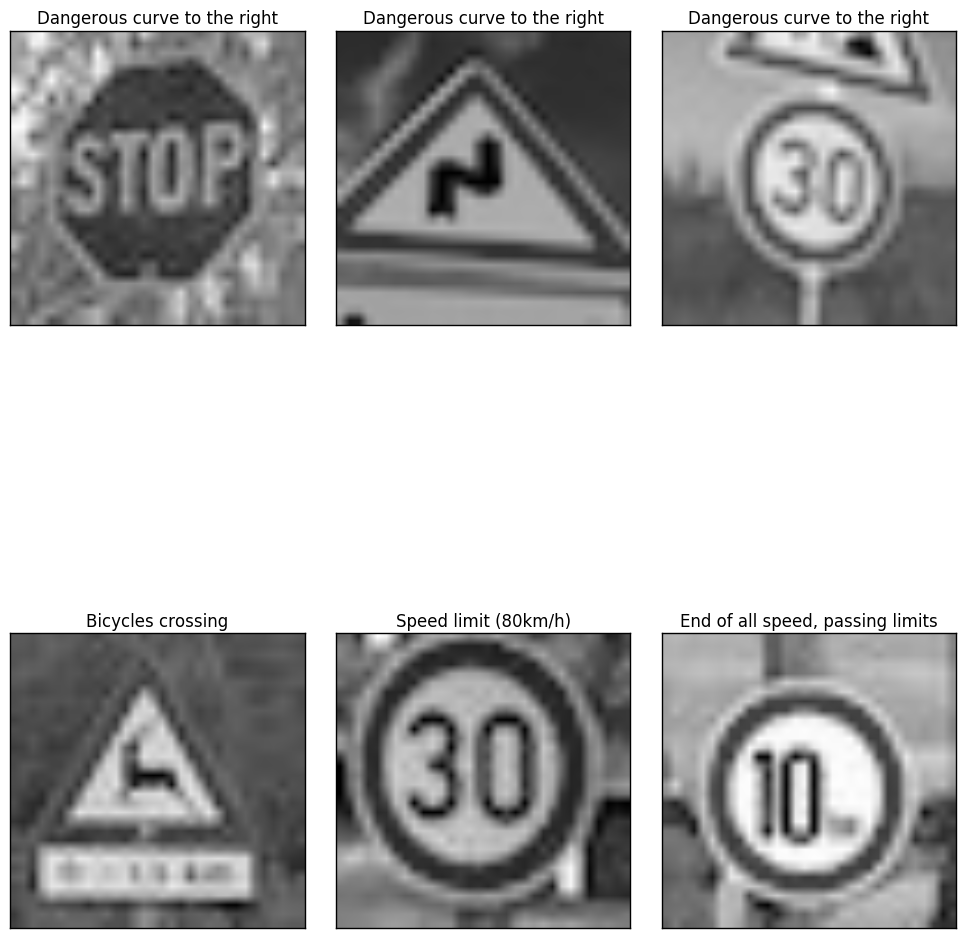

In [148]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
plt.figure(figsize=(10,15))
for i in range(0, numOfSigns):
    axis = plt.subplot(numOfSigns/3,3,i+1)
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    img = Image.fromarray(new_images[i])
    plt.imshow(img)
    plt.title(sign_names[classification[i]][1])
plt.tight_layout()
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
The certainty of all predictions is very low. There is still a lot of work to be done to increase the certainty and accuracy of the model's predictions.

In [149]:
### Get certainty of predictions
new_images_feed_dict = {features: new_images_features}
prediction = tf.nn.softmax(fc2)
probability = tf.nn.top_k(prediction, k=5, sorted=True, name=None)
with tf.Session() as session:
    session.run(init)
    probabilities = probability.values.eval(new_images_feed_dict, session)
print("Probabilities: ", probabilities)

Probabilities:  [[  9.99998331e-01   1.68805298e-06   8.03285083e-09   3.77471476e-09
    6.06948158e-10]
 [  8.24428916e-01   9.37870517e-02   8.00535604e-02   1.66474655e-03
    2.62616450e-05]
 [  9.99996424e-01   2.13375438e-06   6.33999264e-07   3.06748717e-07
    1.69797218e-07]
 [  9.51136887e-01   4.50785048e-02   1.57266366e-03   1.43180368e-03
    3.37439851e-04]
 [  9.99976635e-01   1.61450680e-05   5.00439046e-06   2.15581258e-06
    1.01113919e-07]
 [  9.99964118e-01   2.16629760e-05   5.95858000e-06   4.47350385e-06
    2.22412450e-06]]


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.